#### Install utility to download from Google Drive without authentication

Apapted from https://github.com/ICESAT-2HackWeek/topohack/blob/master/notebooks/driveanon_reference_dem_example.ipynb  

Uncomment the following cell and run.

In [4]:
#import driveanon

#### Download DEM over HMA
Uncomment the following cell and run.

In [3]:
# blob_id = '1-8Ca-9_HJL4S7CrX4x5hzH-nrjD4Thpq'
# ! mkdir ~/shared/data-knuth/
# %cd ~/shared/data-knuth/
# driveanon.save(blob_id)
# %cd {current_directory}

In [4]:
# ! gdalinfo ~/shared/data-knuth/reference_dem_clip.tif

#### Plot DEM

In [5]:
import rasterio
from rasterio.plot import show

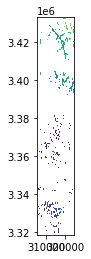

In [6]:
dem_file_name = 'HMA_DEM8m_AT_20140225_0527_102001002B3B5E00_102001002B797800.tif'
rasterio_dataset = rasterio.open(dem_file_name)
show(rasterio_dataset);

#### Reproject

In [7]:
! gdalwarp -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -dstnodata -9999 -r cubic -t_srs EPSG:4326 {dem_file_name} Gangotri_dem_4326.tif

Creating output file that is 3095P x 14258L.
Processing HMA_DEM8m_AT_20140225_0527_102001002B3B5E00_102001002B797800.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image HMA_DEM8m_AT_20140225_0527_102001002B3B5E00_102001002B797800.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [8]:
! gdalinfo Gangotri_dem_4326.tif

Driver: GTiff/GeoTIFF
Files: Gangotri_dem_4326.tif
Size is 3095, 14258
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (78.958228679732812,31.018497950403837)
Pixel Size = (0.000072575092180,-0.000072575092180)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  78.9582287,  31.0184980) ( 78d57'29.62"E, 31d 1' 6.59"N)
Lower Left  (  78.9582287,  29.9837223) ( 78d57'29.62"E, 29d59' 1.40"N)
Upper Ri

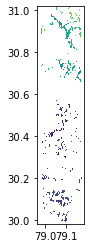

In [9]:
dem_file_name = 'Gangotri_dem_4326.tif'
rasterio_dataset = rasterio.open(dem_file_name)
show(rasterio_dataset);

In [10]:
bounds = list(rasterio_dataset.bounds)

#### Download data using openaltimetry.org API

In [11]:
import requests

In [12]:
base_url = 'https://openaltimetry.org/data/api/icesat2/level3a'

In [13]:
payload =  {'product':'atl06',
            'startDate':'2019-06-16',
#             'endDate':'2020-10-19',
            'minx':str(bounds[0]),
            'miny':str(bounds[1]),
            'maxx':str(bounds[2]),
            'maxy':str(bounds[3]),
            'trackId':'1209',
             'beamName':'gt3r',
#             'beamName':'gt3l',
             'beamName':'gt2r',
#             'beamName':'gt2l',
#             'photonConfidence':'high',
            'outputFormat':'json'}

In [14]:
r = requests.get(base_url, params=payload)
elevation_data = r.json()

#### Extract points and create geodataframe

In [15]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt 
from pyproj import CRS

In [16]:
points = []            
for p in elevation_data['data'][0]['beams'][0]['lat_lon_elev']:
    points.append({
        'lat': p[0],
        'lon': p[1],
        'h': p[2]})

In [17]:
df = pd.DataFrame.from_dict(points)

In [18]:
geometry = [Point(xyz) for xyz in zip(df['lon'], df['lat'], df['h'])]        
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=CRS('EPSG:4326'))

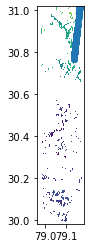

In [19]:
fig,ax = plt.subplots()
show(rasterio_dataset, ax=ax)
gdf.plot(ax=ax);

#### Sample DEM and plot interactively

In [20]:
import hvplot.pandas

In [21]:
laser_hits = list(zip(df['lon'], df['lat']))

dem_elevs = []
for hit in rasterio_dataset.sample(laser_hits):
    dem_elevs.append(hit[0])
    
comparison_df = list(zip(df['lon'], df['lat'], dem_elevs))   

comparison_df = pd.DataFrame.from_dict({'dem_elev': dem_elevs, 
                                        'is2_elev':df['h']})
comparison_df = comparison_df[comparison_df.dem_elev != rasterio_dataset.nodata]

In [22]:
comparison_df.hvplot.scatter()

:NdOverlay   [Variable]
   :Scatter   [index]   (value)

#### Compute differences

In [23]:
comparison_df['diff'] = comparison_df.dem_elev - comparison_df.is2_elev
merged_df = pd.merge(df, comparison_df, right_index=True, left_index=True)
geometry = [Point(xyz) for xyz in zip(merged_df['lon'], merged_df['lat'], merged_df['diff'])]        
merged_gdf = gpd.GeoDataFrame(merged_df, geometry=geometry, crs=CRS('EPSG:4326'))

#### Plot

In [24]:
import contextily as ctx

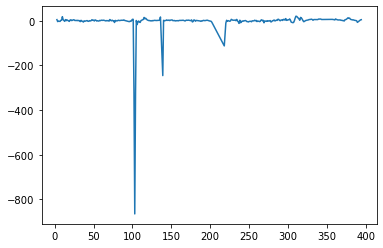

In [25]:
comparison_df['diff'].plot();

In [26]:
merged_gdf = merged_gdf.to_crs(32610)

In [27]:
dem_file_name = 'HMA_DEM8m_AT_20140225_0527_102001002B3B5E00_102001002B797800.tif'
src = rasterio.open(dem_file_name)

In [29]:
#spatial_extent = rasterio.plot.plotting_extent(src)
#fig, ax = plt.subplots(1,figsize=(10,10))
#ax.imshow(src.read(1, masked=True), extent=spatial_extent, alpha=1)
#merged_gdf.plot(column='diff', ax=ax, cmap='RdBu')

In [30]:
url = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'

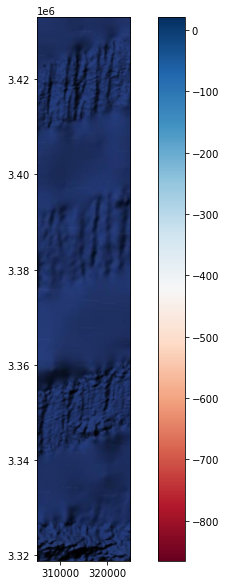

In [31]:
fig, ax = plt.subplots(1,figsize=(10,10))
merged_gdf.plot(column='diff', ax=ax, cmap='RdBu', legend=True)
ax.imshow(src.read(1, masked=True), extent=spatial_extent, alpha=1)
ctx.add_basemap(ax, crs='EPSG:32610', source=url)

#### Looks like distance to ground is being over estimated in the foothills and underestimated towards the peak of the mountain.

#### Compare with ATL03 to investigate what is going on in terms of ATL06 surface detection

In [57]:
# use icepyx to download ATL03

SyntaxError: invalid syntax (<ipython-input-57-3bebfdc5f37c>, line 1)

#### Mask points with RGI and NLCD

Install demcoreg utilities

In [32]:
# %%capture
current_directory = !pwd
current_directory = current_directory[0]
# %cd ~/
! git clone https://github.com/dshean/demcoreg.git
! pip install ./demcoreg
# %cd {current_directory}

fatal: destination path 'demcoreg' already exists and is not an empty directory.
Processing ./demcoreg
Processing /home/jovyan/.cache/pip/wheels/5d/e0/4e/31b0353f538bdfb0ec9018ae013218750cb7f6cc38748be4ce/pygeotools-0.6.0-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02/wget-3.2-py3-none-any.whl
  Created wheel for demcoreg: filename=demcoreg-0.5.0-py3-none-any.whl size=61057 sha256=940dc6160b693ba8b5a834be13dd8d06cd6ea8edea43b0d205b5a9710903a57d
  Stored in directory: /tmp/pip-ephem-wheel-cache-exkxcf5c/wheels/fb/79/18/9d2db74757de4623c00c71a225c6107d0421a6fdd11df15e3b
Successfully built demcoreg


Download RGI and NLCD data

Clip

In [33]:
dem_file_name = 'HMA_DEM8m_AT_20140225_0527_102001002B3B5E00_102001002B797800.tif'
! ~/Db_trial/demcoreg/demcoreg/dem_mask.py {dem_file_name} --glaciers

HMA_DEM8m_AT_20140225_0527_102001002B3B5E00_102001002B797800.tif
25700283 valid pixels in original input tif
Traceback (most recent call last):
  File "/home/jovyan/Db_trial/demcoreg/demcoreg/dem_mask.py", line 647, in <module>
    main()
  File "/home/jovyan/Db_trial/demcoreg/demcoreg/dem_mask.py", line 625, in main
    newmask = get_mask(dem_ds, mask_list, dem_fn=dem_fn, writeout=args.writeout, outdir=args.outdir, args=args)
  File "/home/jovyan/Db_trial/demcoreg/demcoreg/dem_mask.py", line 422, in get_mask
    os.makedirs(outdir)
  File "/srv/conda/envs/notebook/lib/python3.7/os.py", line 221, in makedirs
    mkdir(name, mode)
FileNotFoundError: [Errno 2] No such file or directory: ''


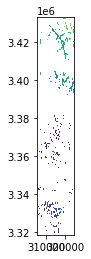

In [34]:
dem_file_name = 'HMA_DEM8m_AT_20140225_0527_102001002B3B5E00_102001002B797800.tif'
rasterio_dataset = rasterio.open(dem_file_name)
show(rasterio_dataset);

In [36]:
# ! gdalwarp -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -dstnodata -9999 -r cubic -t_srs EPSG:4326 {dem_file_name} /home/jovyan/data/reference_dem_clip_ref_4326.tif

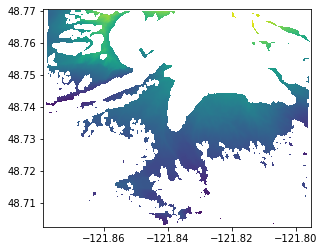

In [37]:
dem_file_name = 'Gangotri_dem_4326.tif'
rasterio_dataset = rasterio.open(dem_file_name)
show(rasterio_dataset);

In [38]:
laser_hits = list(zip(df['lon'], df['lat']))

dem_elevs = []
for hit in rasterio_dataset.sample(laser_hits):
    dem_elevs.append(hit[0])
    
comparison_df = list(zip(df['lon'], df['lat'], dem_elevs))   

comparison_df = pd.DataFrame.from_dict({'dem_elev': dem_elevs, 
                                        'is2_elev':df['h']})
comparison_df = comparison_df[comparison_df.dem_elev != rasterio_dataset.nodata]

In [39]:
comparison_df.hvplot.scatter()

:NdOverlay   [Variable]
   :Scatter   [index]   (value)

In [40]:
comparison_df['diff'] = comparison_df.dem_elev - comparison_df.is2_elev
merged_df = pd.merge(df, comparison_df, right_index=True, left_index=True)
geometry = [Point(xyz) for xyz in zip(merged_df['lon'], merged_df['lat'], merged_df['diff'])]        
merged_gdf = gpd.GeoDataFrame(merged_df, geometry=geometry, crs=CRS('EPSG:4326'))

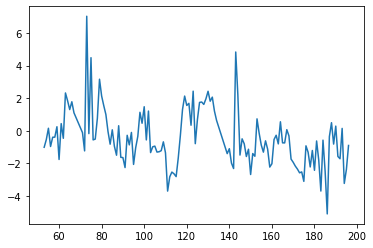

In [41]:
comparison_df['diff'].plot();

In [42]:
merged_gdf = merged_gdf.to_crs(32610)

In [43]:
dem_file_name = '/home/jovyan/shared/data-knuth/reference_dem_clip_ref.tif'
src = rasterio.open(dem_file_name)

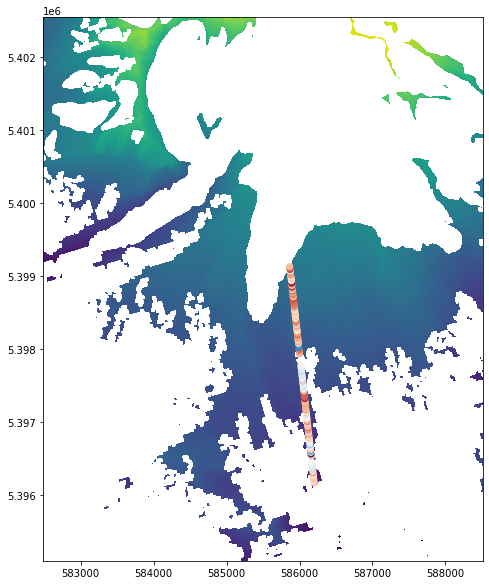

In [44]:
spatial_extent = rasterio.plot.plotting_extent(src)
fig, ax = plt.subplots(1,figsize=(10,10))
ax.imshow(src.read(1, masked=True), extent=spatial_extent, alpha=1)
merged_gdf.plot(column='diff', ax=ax, cmap='RdBu')

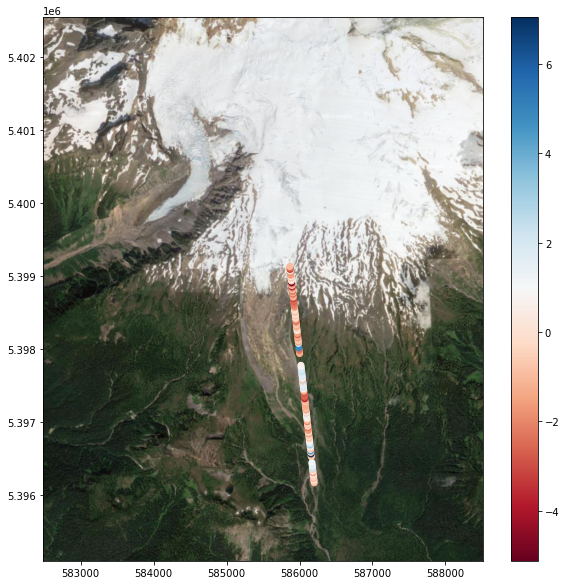

In [45]:
fig, ax = plt.subplots(1,figsize=(10,10))
merged_gdf.plot(column='diff', ax=ax, cmap='RdBu', legend=True)
ax.imshow(src.read(1, masked=True), extent=spatial_extent, alpha=1)
ctx.add_basemap(ax, crs='EPSG:32610', source=url)

#### Mask points with CSNOW
https://ees.kuleuven.be/apps/project-c-snow-data/

Download two staged sample files

In [54]:
# %%capture
# current_directory = !pwd
# current_directory = current_directory[0]
# ! mkdir ~/shared/data-knuth/csnow
# %cd ~/shared/data-knuth/csnow
# driveanon.save('15ptw9YQ4FiDcYUAWfgD3ZYkjJcqNkZD2')
# driveanon.save('15saQldyyAl7RXtvkxJ0GpPJ6S0vJDP6T')
# %cd {current_directory}

In [55]:
import xarray as xr
from datetime import datetime
import glob
import os

In [56]:
nc_file_list = glob.glob('/home/jovyan/shared/data-knuth/csnow/*.nc')

In [57]:
times = []

for nc_file in nc_file_list:
    
    basename    = os.path.basename(nc_file)
    time_string = os.path.splitext(basename)[0][3:]
    time_stamp  = datetime.strptime(time_string, '%Y%m%d')
    
    times.append(time_stamp)

In [58]:
df = xr.open_mfdataset('/home/jovyan/shared/data-knuth/csnow/*.nc', 
                       parallel=True,
                       combine='nested',
                       concat_dim='time')

df = df.assign_coords({'time': times})

In [59]:
df

<xarray.Dataset>
Dimensions:    (lat: 4500, lon: 34703, time: 2)
Coordinates:
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat        (lat) float64 22.6 22.61 22.62 22.63 ... 84.74 84.83 84.91 85.0
  * time       (time) datetime64[ns] 2018-10-14 2018-10-15
Data variables:
    snc        (time, lon, lat) float32 dask.array<chunksize=(1, 34703, 4500), meta=np.ndarray>
    snd_ini    (time, lon, lat) float32 dask.array<chunksize=(1, 34703, 4500), meta=np.ndarray>
    flags_ini  (time, lon, lat) float64 dask.array<chunksize=(1, 34703, 4500), meta=np.ndarray>
    snd_upd    (time, lon, lat) float32 dask.array<chunksize=(1, 34703, 4500), meta=np.ndarray>
    flags_upd  (time, lon, lat) float64 dask.array<chunksize=(1, 34703, 4500), meta=np.ndarray>

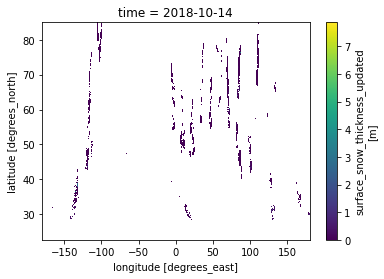

In [60]:
df.sel(time=times[0])['snd_upd'].T.plot.imshow()

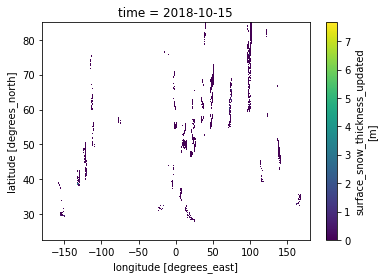

In [61]:
df.sel(time=times[1])['snd_upd'].T.plot.imshow()